# Forecasting
t<sub>0</sub> corresponds to the time at which the forecast is made (12:00 CET) for EPEX SPOT day-ahead auction.<br>

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow import keras
from keras import layers, optimizers, Model

import preprocessing
import models
import utils
import utils_eval
import plotting

In [2]:
print('Pandas version:', pd.__version__)
print('Numpy version:', np.__version__)
print('Tensorflow version:', tf.__version__)

Pandas version: 2.2.3
Numpy version: 2.1.3
Tensorflow version: 2.19.0


In [3]:
config = utils.load_config('config.yaml')

In [4]:
# paths
path = '../../Daten/PVODdatasets_v1/station00.csv'

# model params
model_name = 'tcn'
output_dim = 48 # in hours
batch_size = 16
learning_rate = 0.0004
epochs = 20
n_layers = 2
filters = 64
kernel_size = 2
units = 256
hpo = False
model_validation = True
make_callbacks = False

# data params
freq = '1h'
lag_dim = 48 # in hours
horizon = 48 # in hours
output_dim, lag_dim, horizon = utils.handle_freq(freq=freq, output_dim=output_dim, lag_dim=lag_dim, horizon=horizon)
# data split params
t_0 = 12 # epex spot auction time (12:00 CET)
scale_y = False
lag_in_col = False
return_index = True

# more params
evaluate_on_all_test_data = True

In [5]:
# read data
#df = preprocessing.preprocess_1b_trina(path=path,
#                                       freq=freq)
df = preprocessing.preprocess_pvod(path=path,
                                   freq=freq)

df = utils.impute_index(data=df)
# create temporal features
df = preprocessing.lag_features(df=df,
                                lag_dim=lag_dim,
                                horizon=horizon,
                                lag_in_col=lag_in_col)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7152 entries, 2018-08-17 16:00:00 to 2019-06-13 15:00:00
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   nwp_globalirrad  7152 non-null   float64
 1   nwp_directirrad  7152 non-null   float64
 2   nwp_temperature  7152 non-null   float64
 3   nwp_humidity     7152 non-null   float64
 4   nwp_windspeed    7152 non-null   float64
 5   power            7152 non-null   float64
 6   lag_48           7152 non-null   float64
dtypes: float64(7)
memory usage: 447.0 KB


In [7]:
windows = preprocessing.prepare_data(data=df,
                                     output_dim=output_dim,
                                     scale_y=scale_y)
X_train, y_train, X_test, y_test = windows['X_train'], windows['y_train'], windows['X_test'], windows['y_test']
if return_index:
    index_train, index_test = windows['index_train'], windows['index_test']
    train_end = str(index_train[-1].date())
    test_start = str(index_test[0].date())
scaler = windows['scaler']
scaler_x = scaler[0]
scaler_y = scaler[1]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(5314, 48, 6) (5314, 48) (1721, 48, 6) (1721, 48)


In [8]:
if hpo:
    hyperparameters = utils.load_hyperparams(study_name=study_name,
                                             config=config)
else:
    hyperparameters = {}
    hyperparameters['batch_size'] = batch_size
    hyperparameters['epochs'] = epochs
    hyperparameters['output_dim'] = output_dim
    hyperparameters['n_layers'] = n_layers
    hyperparameters['filters'] = filters
    hyperparameters['kernel_size'] = kernel_size
    hyperparameters['lr'] = learning_rate
    hyperparameters['units'] = units

hyperparameters['model_name'] = model_name

n_features = X_train.shape[2]
model = models.get_model(config=config,
                         n_features=n_features,
                         output_dim=output_dim,
                         hyperparameters=hyperparameters)

In [9]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 6)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 48, 64)         │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 48, 128)        │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6144)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 48)             │       294,960 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 312,304 (1.19 MB)

 Trainable params: 312,304 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
if make_callbacks:
    callbacks = [keras.callbacks.ModelCheckpoint('models/best.keras', save_best_only=True)]

history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = hyperparameters['batch_size'],
    epochs = hyperparameters['epochs'],
    verbose = 'auto',
    callbacks = callbacks if make_callbacks else None,
    validation_data=(X_test, y_test) if model_validation else None,
    shuffle = False
)
if make_callbacks:
    model = keras.models.load_model('models/best.keras')
best_epoch = np.argmin(history.history['val_loss']) + 1

Epoch 1/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0233 - mae: 0.1006 - val_loss: 0.0099 - val_mae: 0.0704
Epoch 2/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0053 - mae: 0.0496 - val_loss: 0.0077 - val_mae: 0.0583
Epoch 3/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0038 - mae: 0.0408 - val_loss: 0.0074 - val_mae: 0.0559
Epoch 4/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0032 - mae: 0.0372 - val_loss: 0.0074 - val_mae: 0.0553
Epoch 5/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0029 - mae: 0.0354 - val_loss: 0.0076 - val_mae: 0.0569
Epoch 6/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0028 - mae: 0.0348 - val_loss: 0.0076 - val_mae: 0.0565
Epoch 7/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0027 - mae: 0.0339 - val_loss: 0.0076 - val_mae: 0.0565
Epoch 8/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0026 - mae: 0.0327 - val_loss: 0.0076 - val_mae: 0.0564
Epoch 9/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - lo

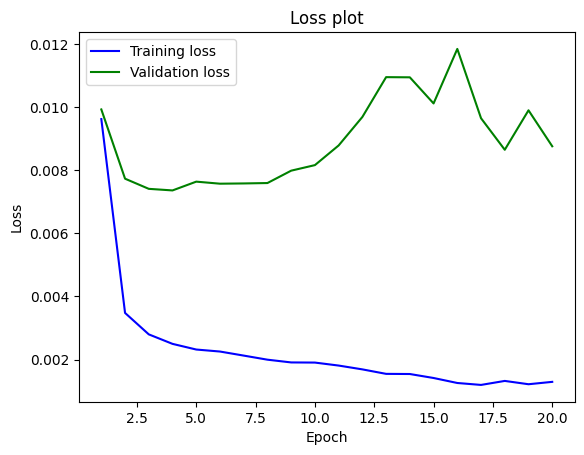

In [11]:
plotting.plot_training(history=history,
                       validation=model_validation,
                       save_name=None)

In [12]:
y_true, y_pred = utils.get_y(X_test=X_test,
                             y_test=y_test,
                             output_dim=output_dim,
                             scaler_y=scaler_y,
                             model=model)
df_pred = utils.y_to_df(y=y_pred,
                        output_dim=output_dim,
                        horizon=horizon,
                        index_test=index_test,
                        t_0=None if evaluate_on_all_test_data else t_0)
df_true = utils.y_to_df(y=y_true,
                        output_dim=output_dim,
                        horizon=horizon,
                        index_test=index_test,
                        t_0=None if evaluate_on_all_test_data else t_0)

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [13]:
persistence = utils_eval.benchmark_models(data=df,
                                     horizon=horizon,
                                     train_end=train_end,
                                     test_start=test_start,
                                     output_dim=output_dim,
                                     index_test=index_test,
                                     t_0=None if evaluate_on_all_test_data else t_0)

In [14]:
results = utils_eval.evaluate_models(pred=df_pred,
                                true=df_true,
                                persistence=persistence)
results

,R^2,RMSE,MAE,Skill
Models,,,,
Main,0.835753,0.092298,0.050356,0.327979
Persistence,0.636308,0.137344,0.067059,0.000000
LinearRegression,0.844405,0.089834,0.048364,0.345919


R^2: 0.8498589843062828
RMSE: 0.07140753577232875
MAE: 0.04068314789910133


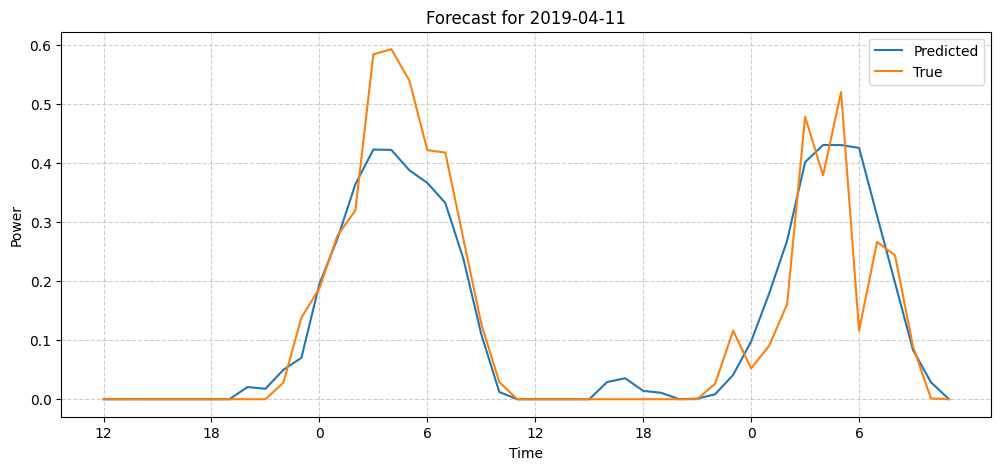

In [15]:
#date = '2018-06-06'
date = plotting.random_date(start_date=test_start,
                            end_date=str(df.index[-1].date()))

plotting.plot_forecast(pred=df_pred,
                       true=df_true,
                       date=date,
                       horizon=horizon,
                       t_0=t_0,
                       figsize=(12,5),
                       print_metric=True,
                       grid=True)

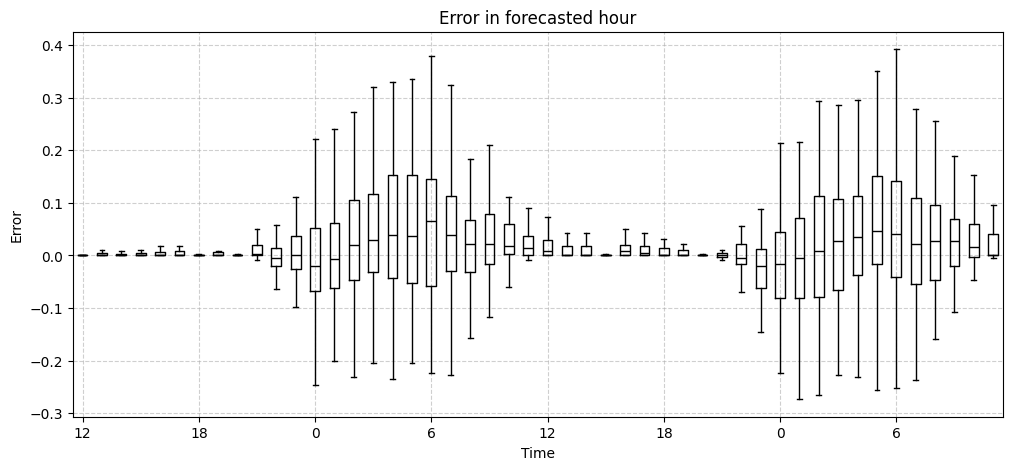

In [16]:
plotting.plot_boxplots(pred=df_pred,
                       true=df_true,
                       t_0=t_0,
                       horizon=horizon,
                       figsize=(12,5),
                       showfliers=False,
                       grid=True)

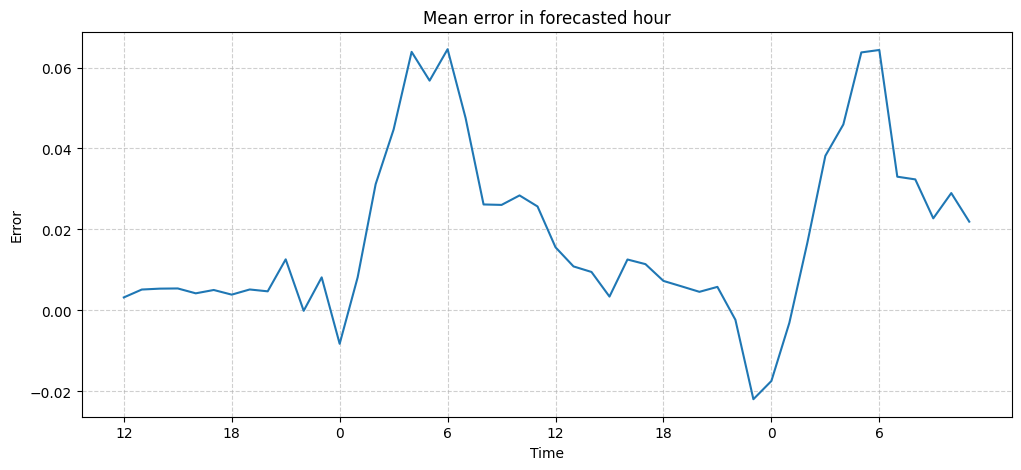

In [17]:
plotting.plot_error(pred=df_pred,
                    true=df_true,
                    t_0=t_0,
                    horizon=horizon,
                    figsize=(12,5),
                    grid=True)

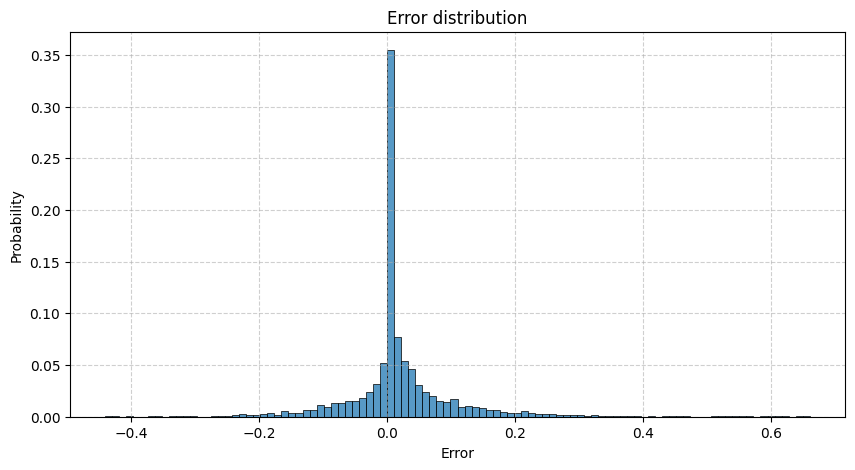

In [18]:
plotting.plot_error_distribution(pred=df_pred,
                                 true=df_true,
                                 figsize=(10,5),
                                 bins=100,
                                 t_0=t_0,
                                 grid=True)